In [38]:
import cupy as np
import matplotlib.pyplot as plt

def M_kappa(x, kappa):
    return 2 / ((x + 1 - 1 / kappa) + np.sqrt((x + 1 - 1 / kappa) ** 2 + 4 * x / kappa))

def e_ICL_g_th(tau, alpha, rho, kappa):
    x_star = (1 + rho) / alpha
    m_star = M_kappa(x_star, kappa)
    mu_star = x_star * M_kappa(x_star, kappa / tau)

    if tau < 1:
        result = tau * (1 + x_star) / (1 - tau) * (1 - tau * (1 - mu_star) ** 2 - (x_star - rho) / x_star * mu_star) - 2 * tau * (1 - mu_star) + rho + 1
    else:
        k_star = (1 - kappa * (m_star / (kappa + m_star)) ** 2) ** -1
        term1 = (k_star - 1 / (tau - 1)) * (1 + x_star) * (x_star * m_star) ** 2
        term2 = (3 - 2 * tau) / (tau - 1) * m_star * (x_star) ** 2
        term3 = ((1 + rho) / (tau - 1) * m_star + 1) * x_star + rho * m_star / (tau - 1) + rho

        result = term1 + term2 + term3

    return result

def draw_pretraining_data(n, d, l, k, rho):
    x = np.random.randn(n, l + 1, d) / np.sqrt(d)
    w_set = np.random.randn(k, d)
    w_indices = np.random.randint(0, k, size=n)
    w = w_set[w_indices]
    epsilon = np.random.randn(n, l + 1) * np.sqrt(rho)
    y = np.einsum('nij,nj->ni', x, w) + epsilon
    return x, y, w

def construct_H_Z(x, y, l, d):
    y_sum_x = np.einsum('nij,ni->nj', x[:, :l, :], y[:, :l])
    y_sum_y = np.sum(y[:, :l] ** 2, axis=1)
    H_Z = np.zeros((x.shape[0], d, d + 1))
    H_Z[:, :, :d] = x[:, l, :, None] * (d / l) * y_sum_x[:, None, :]
    H_Z[:, :, d] = x[:, l] * (1 / l) * y_sum_y[:, None]
    return H_Z

def compute_Gamma_star(n, d, H_Z, y_l1, lambda_val):
    H_Z_vec = H_Z.reshape(n, -1)
    regularization_term = (n / d) * lambda_val * np.eye(H_Z_vec.shape[1])
    # Compute sum of outer products using matrix multiplication
    sum_term = H_Z_vec.T @ H_Z_vec
    # Compute y_l1 weighted sum using broadcasting
    weighted_sum = H_Z_vec.T @ y_l1
    Gamma_star_vec = np.linalg.inv(regularization_term + sum_term) @ weighted_sum
    return Gamma_star_vec.reshape(d, d + 1)

def e_ICL_g_tr(Gamma_star, d, alpha, rho):
    I_d = np.eye(d)
    zero_matrix = np.zeros((d, 1))
    A = np.hstack([I_d, zero_matrix])

    B_top = np.hstack([((1 + rho) / alpha + 1) * I_d, zero_matrix])
    B_bottom = np.hstack([zero_matrix.T, np.array([[1 + rho ** 2]])])
    B = np.vstack([B_top, B_bottom])

    term1 = 1 + rho
    term2 = - (2 / d) * np.trace(Gamma_star @ A.T)
    term3 = (1 / d) * np.trace(Gamma_star.T @ Gamma_star @ B)

    e_icl_g_value = term1 + term2 + term3
    return e_icl_g_value

def monte_carlo_test_error(Gamma_star, d, l, n_test, rho):
    x_test = np.random.randn(n_test, l + 1, d) / np.sqrt(d)
    w_test = np.random.randn(n_test, d)
    epsilon_test = np.random.randn(n_test, l + 1) * np.sqrt(rho)
    y_test = np.einsum('nij,nj->ni', x_test, w_test) + epsilon_test

    # Construct test H_Z
    H_Z_test = construct_H_Z(x_test, y_test, l, d)

    # Predictions
    y_pred = np.einsum('nkl,kl->n', H_Z_test, Gamma_star)

    # Calculate mean squared error
    mse = np.mean((y_pred - y_test[:, l]) ** 2)
    return mse

# Example parameters
d = 120  # Dimension
tau = 0.5
alpha = 0.5  # Example value
n = int(tau * (d ** 2))  # Number of samples
l = int(alpha * d)  # Context length
lambda_val = 0.000001  # Regularization parameter
rho = 0.1  # Example value
n_test = 40000  # Number of test samples
n_MC = 4  # Number of Monte Carlo runs

# Define the range of kappa values
kappa_values = [0.1, 0.3, 0.5, 0.7, 0.9, 1.1, 1.3, 1.5, 1.7, 1.9]

# Initialize empty lists to store the e_ICL_g_tr and e_ICL_g_th values
e_icl_g_tr_values = []
e_icl_g_tr_std = []

# Calculate e_ICL_g_tr and e_ICL_g_th for each kappa value
for kappa in kappa_values:
    print(tau, alpha, kappa)
    k = int(kappa * d)  # Number of unique regression vectors

    # Calculate e_ICL_g_th
    e_icl_g_value_th = e_ICL_g_th(tau, alpha, rho, kappa)
    print("e_ICL_g_th =", e_icl_g_value_th)

    # average over n_MC Monte Carlo runs
    e_icl_g_values = []
    for i in range(n_MC):
        x, y, w = draw_pretraining_data(n, d, l, k, rho)
        H_Z = construct_H_Z(x, y, l, d)
        y_l1 = y[:, l]
        Gamma_star = compute_Gamma_star(n, d, H_Z, y_l1, lambda_val)
        e_icl = e_ICL_g_tr(Gamma_star, d, alpha, rho)
        e_icl_g_values.append(e_icl)

    e_icl_g_values = np.array(e_icl_g_values)  # Convert to CuPy array
    e_icl_g_tr_values.append(np.mean(e_icl_g_values).get())
    e_icl_g_tr_std.append(np.std(e_icl_g_values).get())
    print("e_ICL_g_tr =", np.mean(e_icl_g_values).get())
    print("e_ICL_g_tr std =", np.std(e_icl_g_values).get())

# Plot a fine grained theory curve
kappa_values_th = np.linspace(0.01, 2, 1000)
e_icl_g_th_values = []
for kappa in kappa_values_th:
    e_icl_g_value_th = e_ICL_g_th(tau, alpha, rho, kappa)
    e_icl_g_th_values.append(e_icl_g_value_th)

# Convert results to NumPy arrays for plotting
kappa_values_np = np.array(kappa_values)
e_icl_g_tr_values_np = np.array(e_icl_g_tr_values)
e_icl_g_tr_std_np = np.array(e_icl_g_tr_std)
kappa_values_th_np = np.array(kappa_values_th)
e_icl_g_th_values_np = np.array(e_icl_g_th_values)

# Plot e_ICL_g_tr and e_ICL_g_th as a function of kappa
plt.errorbar(kappa_values_np.get(), e_icl_g_tr_values_np.get(), yerr=e_icl_g_tr_std_np.get(), fmt='o')
plt.plot(kappa_values_th_np.get(), e_icl_g_th_values_np.get(), label='e_ICL_g_th', linestyle='dashed')
plt.xlabel('kappa')
plt.ylabel('e_ICL_g')
plt.legend()
plt.show()



0.5 0.5 0.1
e_ICL_g_th = 1.4898956781741148


OutOfMemoryError: Out of memory allocating 1,686,643,200 bytes (allocated so far: 15,299,796,480 bytes).

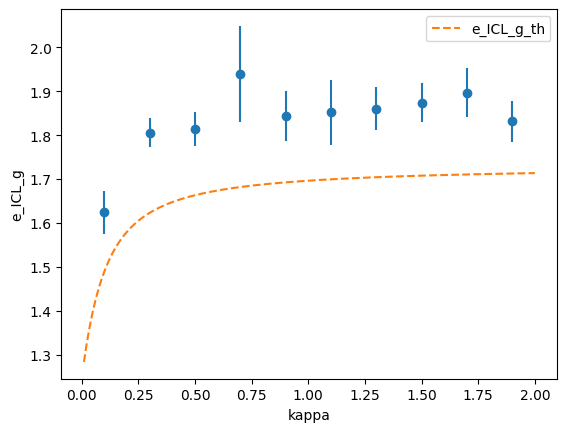

In [24]:

# Plot e_ICL_g_tr and e_ICL_g_th as a function of kappa
plt.errorbar(kappa_values_np.get(), e_icl_g_tr_values_np.get(), yerr=e_icl_g_tr_std_np.get(), fmt='o')
plt.plot(kappa_values_th_np.get(), e_icl_g_th_values_np.get(), label='e_ICL_g_th', linestyle='dashed')
plt.xlabel('kappa')
plt.ylabel('e_ICL_g')
plt.legend()
plt.show()
